<a href="https://colab.research.google.com/github/StanleyLiangYork/2023_journal_club_CNN4N/blob/main/basic_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This demo is based on the Tensorflow tutorial on the official [website](https://www.tensorflow.org/tutorials/quickstart/advanced)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import Model

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


Use the MNIST dataset for this demo

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [3]:
# add the extra channel dimension --> (batch, h, w, c)
x_train = tf.expand_dims(x_train, axis=-1)
x_train = tf.cast(x_train, tf.float32)
# more than one way to do it
x_test = x_test[..., tf.newaxis].astype("float32")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


In [4]:
# load the data to the dataset iterator objects
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [5]:
# define the model architecture
# similar to Pytorch, but inside the class, Pytorch define the forward() method, tensorflow define the call() method
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.pool1 = MaxPooling2D((2,2))
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [6]:
# define the loss objective
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# define the optimizer
LR = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [7]:
# define the metrics to measure the optimization performance
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [8]:
# use the @tf.function tap to let the function run inside the computing graph - imporve runtime performance
@tf.function
def train_step(images, labels):
  # use the tf.GradientTape() to observe the changes of values and compute the gradient 
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True) # enable to compute gradient
    loss = criterion(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables) # compute the gradients
  optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # update the model weights

  train_loss(loss)
  train_accuracy(labels, predictions)

In [9]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = criterion(labels, predictions)
  
  test_loss(t_loss)
  test_accuracy(labels, predictions)


In [10]:
EPOCHS = 10
history = {}
history['train_loss'] = []
history['test_loss'] = []
history['accuracy'] = []
history['val_accuracy'] = []
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  history['train_loss'].append(train_loss.result())
  history['test_loss'].append(test_loss.result())
  history['accuracy'].append(train_accuracy.result())
  history['val_accuracy'].append(test_accuracy.result())

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.8569676876068115, Accuracy: 92.34666442871094, Test Loss: 0.12813018262386322, Test Accuracy: 96.56999969482422
Epoch 2, Loss: 0.09464945644140244, Accuracy: 97.24666595458984, Test Loss: 0.09907694905996323, Test Accuracy: 97.48999786376953
Epoch 3, Loss: 0.057852379977703094, Accuracy: 98.27999877929688, Test Loss: 0.10302502661943436, Test Accuracy: 97.38999938964844
Epoch 4, Loss: 0.039954427629709244, Accuracy: 98.73333740234375, Test Loss: 0.121656633913517, Test Accuracy: 97.31999969482422
Epoch 5, Loss: 0.030985450372099876, Accuracy: 99.02999877929688, Test Loss: 0.15147991478443146, Test Accuracy: 96.88999938964844
Epoch 6, Loss: 0.023311039432883263, Accuracy: 99.27832794189453, Test Loss: 0.15805980563163757, Test Accuracy: 97.39999389648438
Epoch 7, Loss: 0.0182358305901289, Accuracy: 99.46833038330078, Test Loss: 0.16373692452907562, Test Accuracy: 97.61000061035156
Epoch 8, Loss: 0.01957152970135212, Accuracy: 99.49666595458984, Test Loss: 0.186215460300

Plot the training performance

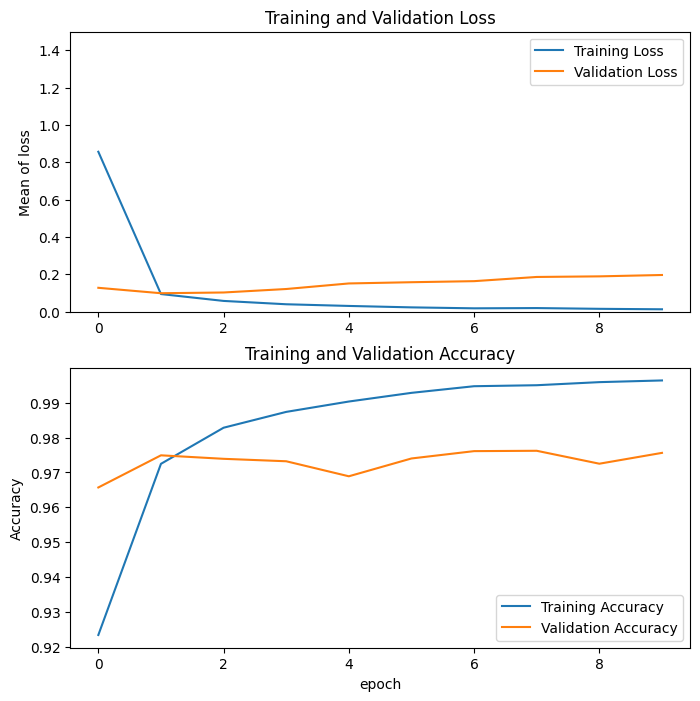

In [11]:
import matplotlib.pyplot as plt

loss = history['train_loss']
val_loss = history['test_loss']
acc = history['accuracy']
val_acc = history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean of loss')
plt.ylim([0, 1.5])
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()